In [1]:
pip install pytorch_fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import models,datasets,transforms
from PIL import Image
from tqdm import tqdm

import os
import matplotlib.pyplot as plt
import numpy as np

from pytorch_fid.fid_score import calculate_activation_statistics,calculate_frechet_distance
from pytorch_fid . inception import InceptionV3
import shutil


In [3]:
class IndexedDataset(Dataset):
    def __init__(self, dir_path):
        self.dir_path = dir_path        
        #The transforms that will be applied to each image
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
          ])
        #Saving all the image locations
        self.image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path): 
            self.image_filenames += [os.path.join(dirpath, file) for file in filenames]
        
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx] #Getting the name of the image
        image = Image.open(img_name).convert('RGB') #opening the image
        image = self.transform(image) #Applying the transforms to the image
        return image


In [4]:
#Inspired from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
def WGAN_Loss(prediction, target_is_real):
  if target_is_real:
    loss = -prediction.mean()
  else:
    loss = prediction.mean()

  return loss


In [5]:
#Inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.convt1 = nn.ConvTranspose2d( 100, 64 * 8, 4, 1, 0, bias=False)
        self.convt2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.convt3 = nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.convt4 = nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False)
        self.convt5 = nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 8)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        
    def forward(self, input):
        x = self.relu(self.bn1(self.convt1(input)))
        x = self.relu(self.bn2(self.convt2(x)))
        x = self.relu(self.bn3(self.convt3(x)))
        x = self.relu(self.bn4(self.convt4(x)))
        x = self.tanh(self.convt5(x))
        return x

In [6]:
#Inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 2)
        self.bn3 = nn.BatchNorm2d(64 * 4) 
        self.bn4 = nn.BatchNorm2d(64 * 8)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, input):
        x = self.relu(self.conv1(input))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        return x

In [7]:
#Initializing the weights
#From https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
#Function to train the model
def training(epochs,optimizerD,optimizerG,criterion,netG,netD,train_data_loader,device,batch_size,model,m1,s1):
  #Storing the losses of the Generator and Discriminator
  train_lossesG = []
  train_lossesD = []
  fid_score = []

  #Assigning labels to the real and fake images
  real_label = 1
  fake_label = 0

  for epoch in range(epochs):
    running_lossG = 0.0
    running_lossD = 0.0
    for i,data in enumerate(train_data_loader):
      #Part 1: Training the Discriminator
      #Part A: On the real images
      optimizerD.zero_grad()
      inputs_real = data.to(device) #Getting the real image
      num_images = data.shape[0] #Getting the batch size
            
      outputs_real = netD(inputs_real).view(-1) #Getting the predicted labels for the real images
      loss_real = criterion(outputs_real, real_label) #Calculating the loss on real images
      loss_real.backward()

      #Part B: On the fake images
      noise = torch.randn((num_images,100,1,1)).to(device) #Generating the loss
      inputs_fake = netG(noise) #Generating the fake images from this noise
      outputs_fake = netD(inputs_fake.detach()).view(-1) #Getting the predicted labels for the fake images
      loss_fake = criterion(outputs_fake, fake_label) #Calculating the loss on fake images
      loss_fake.backward()

      optimizerD.step()
      running_lossD += loss_real.cpu().item() + loss_fake.cpu().item()
      
      clipping_thresh = 0.01
      #Weight clipping which enforces 1-Lipschitz constraint
      for p in netD.parameters():
        p.data.clamp_(-clipping_thresh, clipping_thresh)

      #Part 2: Training the Generator
      optimizerG.zero_grad()
      outputs_fake_G = netD(inputs_fake).view(-1) #Genrating the predicted labels for the fake images
      loss_G = criterion(outputs_fake_G, real_label) #In the optimum case the fake images should be predicted as real by the discriminator
      loss_G.backward()
      optimizerG.step()
      running_lossG += loss_G.cpu().item()

    print("[epoch: %d, batch: %5d] Discriminator loss: %.3f Generator loss: %.3f" % (epoch + 1, i + 1, (running_lossD)/(i+1),(running_lossG)/(i+1)))
    train_lossesG.append(running_lossG/len(train_data_loader.dataset))
    train_lossesD.append(running_lossD/len(train_data_loader.dataset))
    fid = calc_fid(netG,device,m1,s1,model)
    fid_score.append(fid)
  return netG, train_lossesG, train_lossesD, fid_score

In [9]:
#Function to Plot a real image
def plot_image_real(dataset,index):
  img = dataset[index] #Getting the image
  i = np.transpose(np.asarray(img*127.5 + 127.5).astype(int),(1,2,0)) #converting the image from tensor to numpy
  ci = np.ascontiguousarray(i, dtype=np.uint8) #Making the array contiguous  
  return ci.astype(int)  #returns the image 

In [10]:
#Function to Plot a fake image
def plot_image_fake(netG,device):
  noise = torch.randn((1,100,1,1)).to(device)
  img = netG(noise).cpu().detach() #Getting the image
  img = img.squeeze()
  i = np.transpose(np.asarray(img*127.5 + 127.5).astype(int),(1,2,0)) #converting the image from tensor to numpy
  ci = np.ascontiguousarray(i, dtype=np.uint8) #Making the array contiguous  
  return ci.astype(int)  #returns the image 

In [11]:
#Function to save a fake image
def save_image_fake(img,i):
  im = Image.fromarray(img.astype(np.uint8))
  im.save("fake/"+str(i)+".jpeg")

In [12]:
#Function to calculate FID
def calc_fid(netG,device,m1,s1,model):
  #Generating 1000 fake images
  for i in range(1000):
    img = plot_image_fake(netG,device)
    save_image_fake(img,i)
  fake_paths = ["fake/" +str(i)+".jpeg" for i in range(0, 1000)] #Generating the path for the directory containing fake images
  #Obtaining the feature encoding for the real test images
  m2 , s2 = calculate_activation_statistics(fake_paths, model,device = device)
  fid_value = calculate_frechet_distance(m1,s1,m2,s2) #Calculating FID value
  print("FID: "+str(fid_value)) 
  return fid_value

In [13]:
#Function to Plot 4x4 images
def plot_collage(dataset,device,type_of="real",model=None):
  images = []
  if type_of=="real": #If you want real image generated
    indices = np.random.randint(0,len(dataset),16) #Getting 16 random indices
    for i in indices:
      images.append(plot_image_real(dataset,i)) #Saving the 16 images

  elif type_of=="fake": #If you want fake image generated
    for i in range(16):
      images.append(plot_image_fake(model,device)) #Saving the 16 images

  fig = plt.figure(figsize = (10,10))

  ax11 = fig.add_subplot(4,4,1)
  ax12 = fig.add_subplot(4,4,2)
  ax13 = fig.add_subplot(4,4,3)
  ax14 = fig.add_subplot(4,4,4)
  ax21 = fig.add_subplot(4,4,5)
  ax22 = fig.add_subplot(4,4,6)
  ax23 = fig.add_subplot(4,4,7)
  ax24 = fig.add_subplot(4,4,8)
  ax31 = fig.add_subplot(4,4,9)
  ax32 = fig.add_subplot(4,4,10)
  ax33 = fig.add_subplot(4,4,11)
  ax34 = fig.add_subplot(4,4,12)
  ax41 = fig.add_subplot(4,4,13)
  ax42 = fig.add_subplot(4,4,14)
  ax43 = fig.add_subplot(4,4,15)
  ax44 = fig.add_subplot(4,4,16)

  ax11.axis('off')
  ax12.axis('off')
  ax13.axis('off')
  ax14.axis('off')
  ax21.axis('off')
  ax22.axis('off')
  ax23.axis('off')
  ax24.axis('off')
  ax31.axis('off')
  ax32.axis('off')
  ax33.axis('off')
  ax34.axis('off')
  ax41.axis('off')
  ax42.axis('off')
  ax43.axis('off')
  ax44.axis('off')

  ax11.imshow(images[0])
  ax12.imshow(images[1])
  ax13.imshow(images[2])
  ax14.imshow(images[3])
  ax21.imshow(images[4])
  ax22.imshow(images[5])
  ax23.imshow(images[6])
  ax24.imshow(images[7])
  ax31.imshow(images[8])
  ax32.imshow(images[9])
  ax33.imshow(images[10])
  ax34.imshow(images[11])
  ax41.imshow(images[12])
  ax42.imshow(images[13])
  ax43.imshow(images[14])
  ax44.imshow(images[15])     

In [14]:
train_dataset = IndexedDataset("/content/drive/MyDrive/pizzas/train")
test_dataset = IndexedDataset("/content/drive/MyDrive/pizzas/eval")

train_dataloader = DataLoader(train_dataset,batch_size=16,num_workers=64)
test_dataloader = DataLoader(test_dataset,batch_size=16,num_workers=64)

print(len(train_dataloader))
print(len(test_dataloader))

514
63


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0001, betas = (0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0001, betas = (0.5, 0.999))
criterion = WGAN_Loss
epochs = 40



In [17]:
#The number of parameters in the Generator
sum(p.numel() for p in netG.parameters() if p.requires_grad)

3576704

In [18]:
#The number of parameters in the Discriminator
sum(p.numel() for p in netD.parameters() if p.requires_grad)

2765568

In [19]:
#Creating an instance of the InceptionV3 model
dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

In [20]:
#Obtaining the feature encoding for the real test images
real_paths = test_dataset.image_filenames
m1 , s1 = calculate_activation_statistics(real_paths,model,device = device)

100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


In [21]:
trained_generator,train_lossesG, train_lossesD,fid_score = training(epochs,optimizerD,optimizerG,criterion,netG,netD,train_dataloader,device,16,model,m1,s1)

[epoch: 1, batch:   514] Discriminator loss: -0.035 Generator loss: 0.035


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


FID: 312.71542824865946
[epoch: 2, batch:   514] Discriminator loss: -0.702 Generator loss: 0.467


100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


FID: 319.2183011375573
[epoch: 3, batch:   514] Discriminator loss: -0.817 Generator loss: 0.414


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


FID: 273.9275918819934
[epoch: 4, batch:   514] Discriminator loss: -0.733 Generator loss: 0.308


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


FID: 261.0680852720418
[epoch: 5, batch:   514] Discriminator loss: -0.819 Generator loss: 0.424


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


FID: 270.27719277368533
[epoch: 6, batch:   514] Discriminator loss: -0.948 Generator loss: 0.582


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


FID: 241.41450050477388
[epoch: 7, batch:   514] Discriminator loss: -0.940 Generator loss: 0.521


100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


FID: 232.71191620810427
[epoch: 8, batch:   514] Discriminator loss: -0.973 Generator loss: 0.575


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


FID: 237.16392783717143
[epoch: 9, batch:   514] Discriminator loss: -0.939 Generator loss: 0.529


100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


FID: 204.21158146544775
[epoch: 10, batch:   514] Discriminator loss: -0.974 Generator loss: 0.548


100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


FID: 216.7946180100767
[epoch: 11, batch:   514] Discriminator loss: -0.959 Generator loss: 0.566


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


FID: 196.6523105348622
[epoch: 12, batch:   514] Discriminator loss: -0.946 Generator loss: 0.560


100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


FID: 205.09925149320358
[epoch: 13, batch:   514] Discriminator loss: -0.950 Generator loss: 0.557


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


FID: 210.94639086222466
[epoch: 14, batch:   514] Discriminator loss: -0.934 Generator loss: 0.551


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


FID: 194.35634267731098
[epoch: 15, batch:   514] Discriminator loss: -0.937 Generator loss: 0.551


100%|██████████| 20/20 [00:04<00:00,  4.37it/s]


FID: 189.222501235485
[epoch: 16, batch:   514] Discriminator loss: -0.922 Generator loss: 0.542


100%|██████████| 20/20 [00:04<00:00,  4.35it/s]


FID: 194.98487252376694
[epoch: 17, batch:   514] Discriminator loss: -0.895 Generator loss: 0.536


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


FID: 209.71472088101368
[epoch: 18, batch:   514] Discriminator loss: -0.883 Generator loss: 0.530


100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


FID: 188.96847985491024
[epoch: 19, batch:   514] Discriminator loss: -0.863 Generator loss: 0.524


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


FID: 195.4969132681743
[epoch: 20, batch:   514] Discriminator loss: -0.843 Generator loss: 0.515


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


FID: 179.07087889591548
[epoch: 21, batch:   514] Discriminator loss: -0.833 Generator loss: 0.510


100%|██████████| 20/20 [00:04<00:00,  4.43it/s]


FID: 184.56681718992408
[epoch: 22, batch:   514] Discriminator loss: -0.839 Generator loss: 0.509


100%|██████████| 20/20 [00:04<00:00,  4.33it/s]


FID: 180.35679215171368
[epoch: 23, batch:   514] Discriminator loss: -0.826 Generator loss: 0.506


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


FID: 177.93283493955084
[epoch: 24, batch:   514] Discriminator loss: -0.829 Generator loss: 0.502


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


FID: 178.50329366406254
[epoch: 25, batch:   514] Discriminator loss: -0.830 Generator loss: 0.503


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


FID: 173.02638585636657
[epoch: 26, batch:   514] Discriminator loss: -0.821 Generator loss: 0.500


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


FID: 177.34094361716515
[epoch: 27, batch:   514] Discriminator loss: -0.823 Generator loss: 0.499


100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


FID: 170.47102673806478
[epoch: 28, batch:   514] Discriminator loss: -0.818 Generator loss: 0.495


100%|██████████| 20/20 [00:04<00:00,  4.39it/s]


FID: 162.23216112908113
[epoch: 29, batch:   514] Discriminator loss: -0.827 Generator loss: 0.498


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


FID: 165.50774877547792
[epoch: 30, batch:   514] Discriminator loss: -0.836 Generator loss: 0.497


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


FID: 159.93925892111395
[epoch: 31, batch:   514] Discriminator loss: -0.846 Generator loss: 0.501


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


FID: 164.3630864068361
[epoch: 32, batch:   514] Discriminator loss: -0.857 Generator loss: 0.503


100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


FID: 164.30597834217508
[epoch: 33, batch:   514] Discriminator loss: -0.862 Generator loss: 0.502


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]


FID: 161.36161519124747
[epoch: 34, batch:   514] Discriminator loss: -0.876 Generator loss: 0.504


100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


FID: 155.34500242822025
[epoch: 35, batch:   514] Discriminator loss: -0.879 Generator loss: 0.508


100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


FID: 160.54555032686798
[epoch: 36, batch:   514] Discriminator loss: -0.897 Generator loss: 0.512


100%|██████████| 20/20 [00:04<00:00,  4.25it/s]


FID: 163.767130325518
[epoch: 37, batch:   514] Discriminator loss: -0.877 Generator loss: 0.503


100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


FID: 152.96835832580416
[epoch: 38, batch:   514] Discriminator loss: -0.895 Generator loss: 0.507


100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


FID: 152.16208751277938
[epoch: 39, batch:   514] Discriminator loss: -0.884 Generator loss: 0.501


100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


FID: 157.50809853266796
[epoch: 40, batch:   514] Discriminator loss: -0.881 Generator loss: 0.502


100%|██████████| 20/20 [00:04<00:00,  4.24it/s]


FID: 148.3584119887094


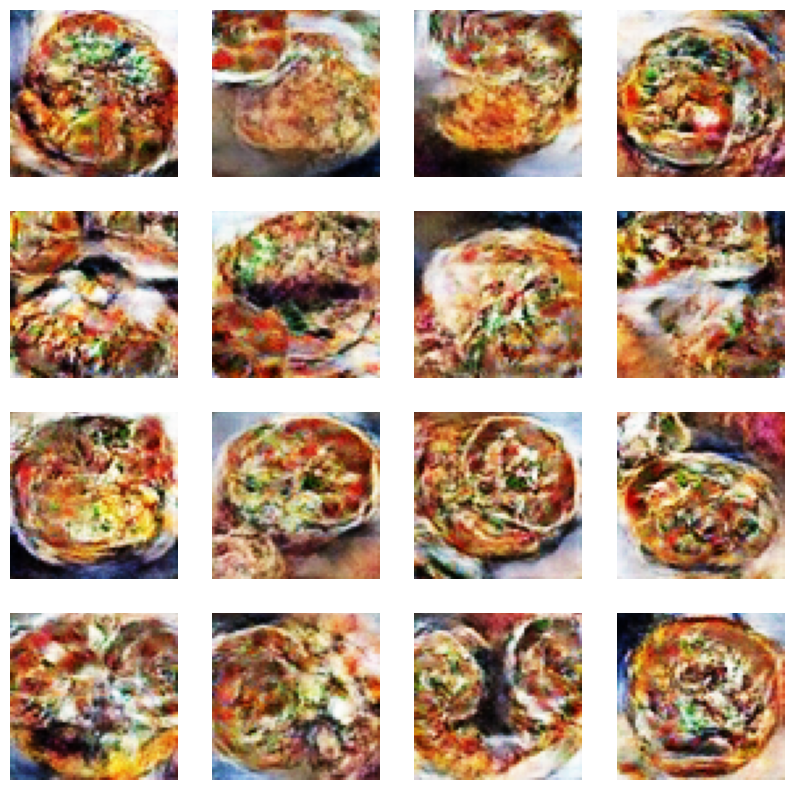

In [22]:
#Fake images
plot_collage(train_dataset,device,type_of="fake",model=trained_generator)

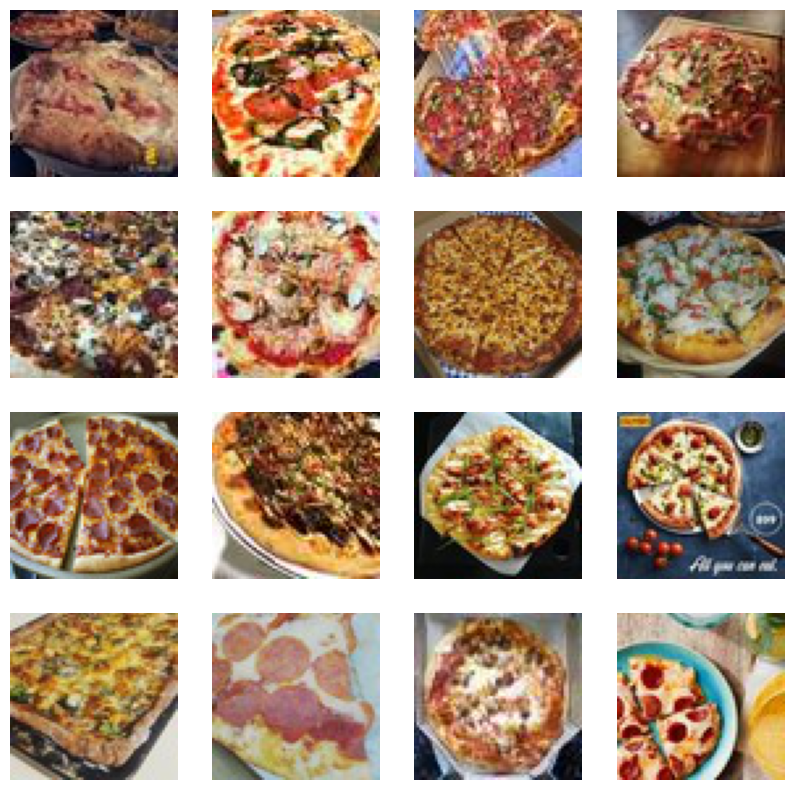

In [23]:
#Real Images
plot_collage(train_dataset,device,type_of="real",model=None)

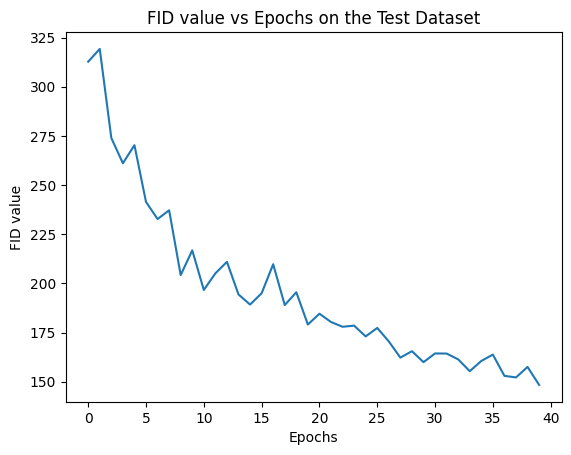

In [24]:
plt.xlabel("Epochs")
plt.ylabel("FID value")
plt.title("FID value vs Epochs on the Test Dataset")
plt.plot(fid_score)

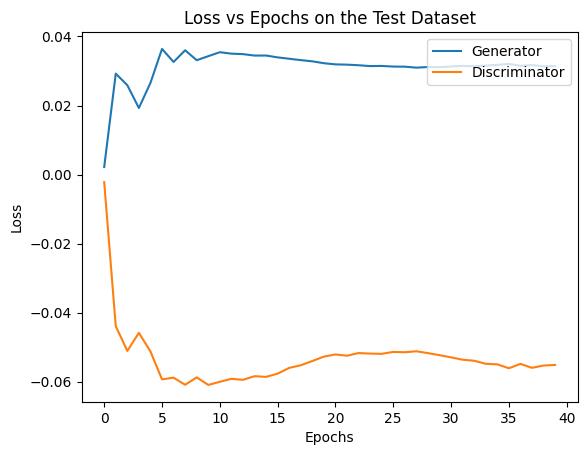

In [25]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs on the Test Dataset") #This should be training dataset
plt.plot(train_lossesG,label="Generator")
plt.plot(train_lossesD, label="Discriminator")
plt.legend(loc = "upper right")